<a href="https://www.kaggle.com/code/voideans/amp-parkinsons-analytics?scriptVersionId=121861069" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/amp-parkinsons-disease-progression-prediction/train_proteins.csv
/kaggle/input/amp-parkinsons-disease-progression-prediction/train_clinical_data.csv
/kaggle/input/amp-parkinsons-disease-progression-prediction/public_timeseries_testing_util.py
/kaggle/input/amp-parkinsons-disease-progression-prediction/supplemental_clinical_data.csv
/kaggle/input/amp-parkinsons-disease-progression-prediction/train_peptides.csv
/kaggle/input/amp-parkinsons-disease-progression-prediction/amp_pd_peptide/competition.cpython-37m-x86_64-linux-gnu.so
/kaggle/input/amp-parkinsons-disease-progression-prediction/amp_pd_peptide/__init__.py
/kaggle/input/amp-parkinsons-disease-progression-prediction/example_test_files/sample_submission.csv
/kaggle/input/amp-parkinsons-disease-progression-prediction/example_test_files/test_proteins.csv
/kaggle/input/amp-parkinsons-disease-progression-prediction/example_test_files/test_peptides.csv
/kaggle/input/amp-parkinsons-disease-progression-prediction/example_test

# Reading the Data

In [2]:
# reading the data
supp = pd.read_csv("/kaggle/input/amp-parkinsons-disease-progression-prediction/supplemental_clinical_data.csv")
clinical = pd.read_csv("/kaggle/input/amp-parkinsons-disease-progression-prediction/train_clinical_data.csv")
peptides = pd.read_csv("/kaggle/input/amp-parkinsons-disease-progression-prediction/train_peptides.csv")
proteins = pd.read_csv("/kaggle/input/amp-parkinsons-disease-progression-prediction/train_proteins.csv")

# **Data Pre-Processing**

In [3]:
# renaming the column 'upd23b_clinical_state_on_medication' --> 'med_state'
supp = supp.rename(columns={'upd23b_clinical_state_on_medication': 'med_state'})
clinical = clinical.rename(columns={'upd23b_clinical_state_on_medication': 'med_state'})

print("renamed successfully")

renamed successfully


In [4]:
# replacing 'On' with 1 and 'Off' with 0 for the med_state column
supp.replace({'Off':0,'On':1}, inplace=True)
supp['med_state'] = pd.to_numeric(supp['med_state'])

clinical.replace({'Off':0,'On':1}, inplace=True)
clinical['med_state'] = pd.to_numeric(clinical['med_state'])

print('replaced successfully')

replaced successfully


# **Merging the datasets**

In [5]:
# merging peptides and protiens
pep_pro = pd.merge(peptides, proteins, how = 'outer',
                   on=['visit_id','visit_month', 'patient_id','UniProt'])   
pep_pro.head(2)

,visit_id,visit_month,patient_id,UniProt,Peptide,PeptideAbundance,NPX
0,55_0,0,55,O00391,NEQEQPLGQWHLS,11254.3,11254.3
1,55_0,0,55,O00533,GNPEPTFSWTK,102060.0,732430.0


In [6]:
#  merging clinical and pep_pro
merged_data = pd.merge(clinical, pep_pro, how='outer',
                       on=['visit_id','visit_month', 'patient_id'])   
merged_data.head()

,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,med_state,UniProt,Peptide,PeptideAbundance,NPX
0,55_0,55,0,10.0,6.0,15.0,NaN,NaN,O00391,NEQEQPLGQWHLS,11254.3,11254.3
1,55_0,55,0,10.0,6.0,15.0,NaN,NaN,O00533,GNPEPTFSWTK,102060.0,732430.0
2,55_0,55,0,10.0,6.0,15.0,NaN,NaN,O00533,IEIPSSVQQVPTIIK,174185.0,732430.0
3,55_0,55,0,10.0,6.0,15.0,NaN,NaN,O00533,KPQSAVYSTGSNGILLC(UniMod_4)EAEGEPQPTIK,27278.9,732430.0
4,55_0,55,0,10.0,6.0,15.0,NaN,NaN,O00533,SMEQNGPGLEYR,30838.7,732430.0


In [7]:
# merging merged_data and supp
merged = pd.merge(supp, merged_data, how='outer',
                  on=['visit_id', 'patient_id','visit_month'])   
merged.head()

,visit_id,patient_id,visit_month,updrs_1_x,updrs_2_x,updrs_3_x,updrs_4_x,med_state_x,updrs_1_y,updrs_2_y,updrs_3_y,updrs_4_y,med_state_y,UniProt,Peptide,PeptideAbundance,NPX
0,35_0,35,0,5.0,3.0,16.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,35_36,35,36,6.0,4.0,20.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,75_0,75,0,4.0,6.0,26.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,75_36,75,36,1.0,8.0,38.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,155_0,155,0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
merged[merged['med_state_x'].notnull() & merged['med_state_y'].notnull()].shape
# merged[merged['updrs_1_y'].isna()]
# merged[merged['updrs_1_y'].notnull()]

# it has been observed from above that regarding updrs columns of supp and clinical, there are no rows where both corresponding columns return non-null values. So it is safe to merge updrs_x and updrs_y

# But since there are both NaN and 0.0 values, we will need to preserve NaN as is

(0, 17)

In [9]:
# merging updrs_x and updrs_y to one column

x = ['updrs_1_x','updrs_2_x','updrs_3_x','updrs_4_x','med_state_x']
y = ['updrs_1_y','updrs_2_y','updrs_3_y','updrs_4_y','med_state_y']
o = ['updrs_1','updrs_2','updrs_3','updrs_4','med_state']

for x_col, y_col, o_col in zip(x, y, o):
    merged[o_col] = merged[[x_col, y_col]].max(axis=1)
merged.head()

,visit_id,patient_id,visit_month,updrs_1_x,updrs_2_x,updrs_3_x,updrs_4_x,med_state_x,updrs_1_y,updrs_2_y,...,med_state_y,UniProt,Peptide,PeptideAbundance,NPX,updrs_1,updrs_2,updrs_3,updrs_4,med_state
0,35_0,35,0,5.0,3.0,16.0,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,5.0,3.0,16.0,0.0,NaN
1,35_36,35,36,6.0,4.0,20.0,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,6.0,4.0,20.0,0.0,NaN
2,75_0,75,0,4.0,6.0,26.0,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,4.0,6.0,26.0,0.0,NaN
3,75_36,75,36,1.0,8.0,38.0,0.0,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,8.0,38.0,0.0,1.0
4,155_0,155,0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN


In [10]:
# # merging med_state columns
# # if-else conditions give errors here
# merged['med_state'] = np.where(merged[['med_state_x', 'med_state_y']].eq('On').any(axis=1), 'On', np.nan)

# # replacing the 'nan' string with NaN value
# merged['med_state'].replace('nan',np.nan,inplace=True)
    

In [11]:
# verifying if the values were saved corrctly
print(merged[merged['med_state_x'] == 1].shape)
print(merged[(merged['med_state_x'] == 1) & (merged['med_state'] == 1)].shape)


(1093, 22)
(1093, 22)


In [12]:
# removing unwanted columns

data = merged.drop(['updrs_1_x','updrs_2_x','updrs_3_x','updrs_4_x','med_state_x','updrs_1_y','updrs_2_y','updrs_3_y','updrs_4_y','med_state_y'], axis=1)
data.head()

,visit_id,patient_id,visit_month,UniProt,Peptide,PeptideAbundance,NPX,updrs_1,updrs_2,updrs_3,updrs_4,med_state
0,35_0,35,0,NaN,NaN,NaN,NaN,5.0,3.0,16.0,0.0,NaN
1,35_36,35,36,NaN,NaN,NaN,NaN,6.0,4.0,20.0,0.0,NaN
2,75_0,75,0,NaN,NaN,NaN,NaN,4.0,6.0,26.0,0.0,NaN
3,75_36,75,36,NaN,NaN,NaN,NaN,1.0,8.0,38.0,0.0,1.0
4,155_0,155,0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN


# Visualization

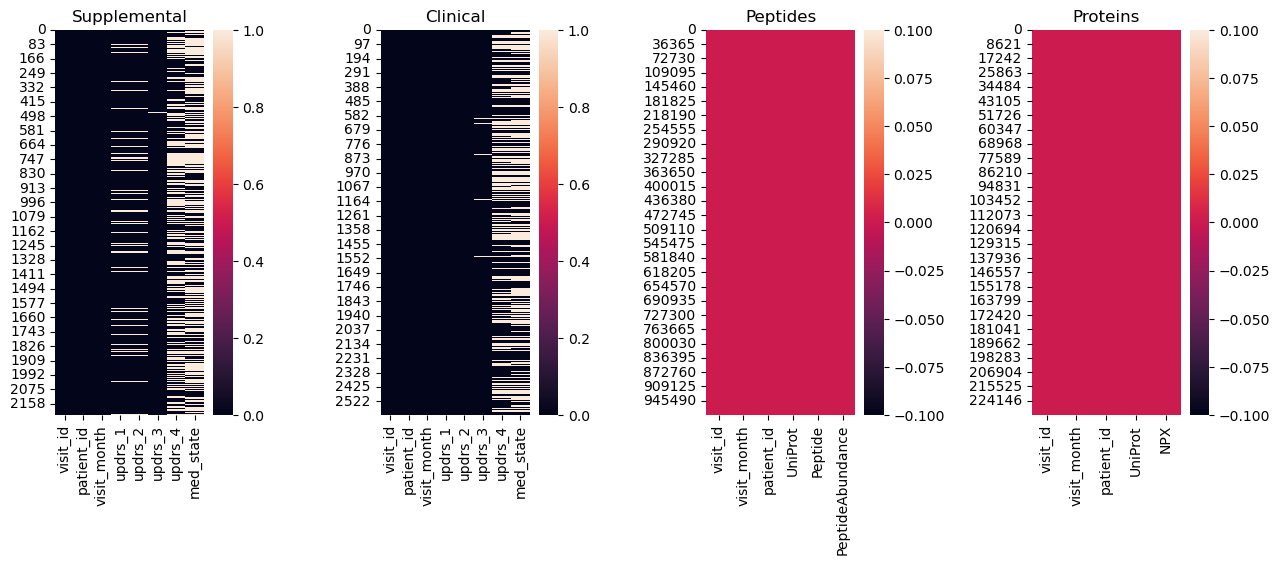

In [13]:
# Create a 2x2 grid of subplots
# figzise = (w,h)
fig, axs = plt.subplots(1, 4, figsize=(15,5))
fig.subplots_adjust(hspace=0.5, wspace=0.75)
sns.heatmap(supp.isnull(), ax=axs[0])
sns.heatmap(clinical.isnull(), ax=axs[1])
sns.heatmap(peptides.isnull(), ax=axs[2])
sns.heatmap(proteins.isnull(), ax=axs[3])

# Set titles for each subplot
axs[0].set_title('Supplemental')
axs[1].set_title('Clinical')
axs[2].set_title('Peptides')
axs[3].set_title('Proteins')

plt.show()

In [14]:
data

,visit_id,patient_id,visit_month,UniProt,Peptide,PeptideAbundance,NPX,updrs_1,updrs_2,updrs_3,updrs_4,med_state
0,35_0,35,0,NaN,NaN,NaN,NaN,5.0,3.0,16.0,0.0,NaN
1,35_36,35,36,NaN,NaN,NaN,NaN,6.0,4.0,20.0,0.0,NaN
2,75_0,75,0,NaN,NaN,NaN,NaN,4.0,6.0,26.0,0.0,NaN
3,75_36,75,36,NaN,NaN,NaN,NaN,1.0,8.0,38.0,0.0,1.0
4,155_0,155,0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
985599,12703_108,12703,108,Q9UHG2,ILAGSADSEGVAAPR,194309.00,326307.0,NaN,NaN,NaN,NaN,NaN
985600,12703_108,12703,108,Q9UKV8,SGNIPAGTTVDTK,33346.90,33346.9,NaN,NaN,NaN,NaN,NaN
985601,12703_108,12703,108,Q9Y646,LALLVDTVGPR,23710.20,23710.2,NaN,NaN,NaN,NaN,NaN
985602,12703_108,12703,108,Q9Y6R7,AGC(UniMod_4)VAESTAVC(UniMod_4)R,3631.35,13366.7,NaN,NaN,NaN,NaN,NaN


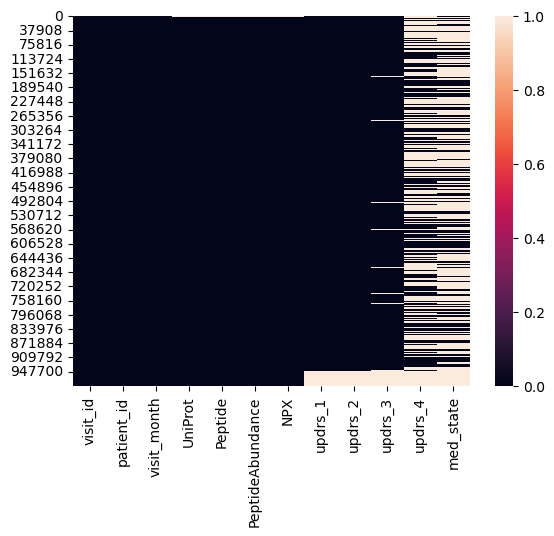

In [15]:
sns.heatmap(data.isnull())
plt.show()

In [16]:
# checking shape of data
print("supplemental: {a}\nclinical: {b}\npeptides: {c}\nprotein: {d}\n".format(a = supp.shape,b = clinical.shape,c = peptides.shape,d = proteins.shape,))

supplemental: (2223, 8)
clinical: (2615, 8)
peptides: (981834, 6)
protein: (232741, 5)



In [17]:
# Dropping null rows
data_val=data.dropna(subset=['updrs_1','updrs_2','updrs_3','UniProt','Peptide','PeptideAbundance','NPX'])

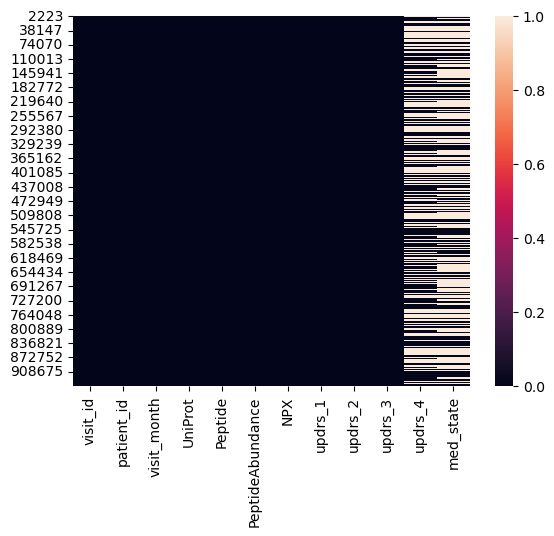

In [18]:
# method 1: Vizualizing after dropping values
sns.heatmap(data_val.isnull())
plt.show()

<AxesSubplot:>

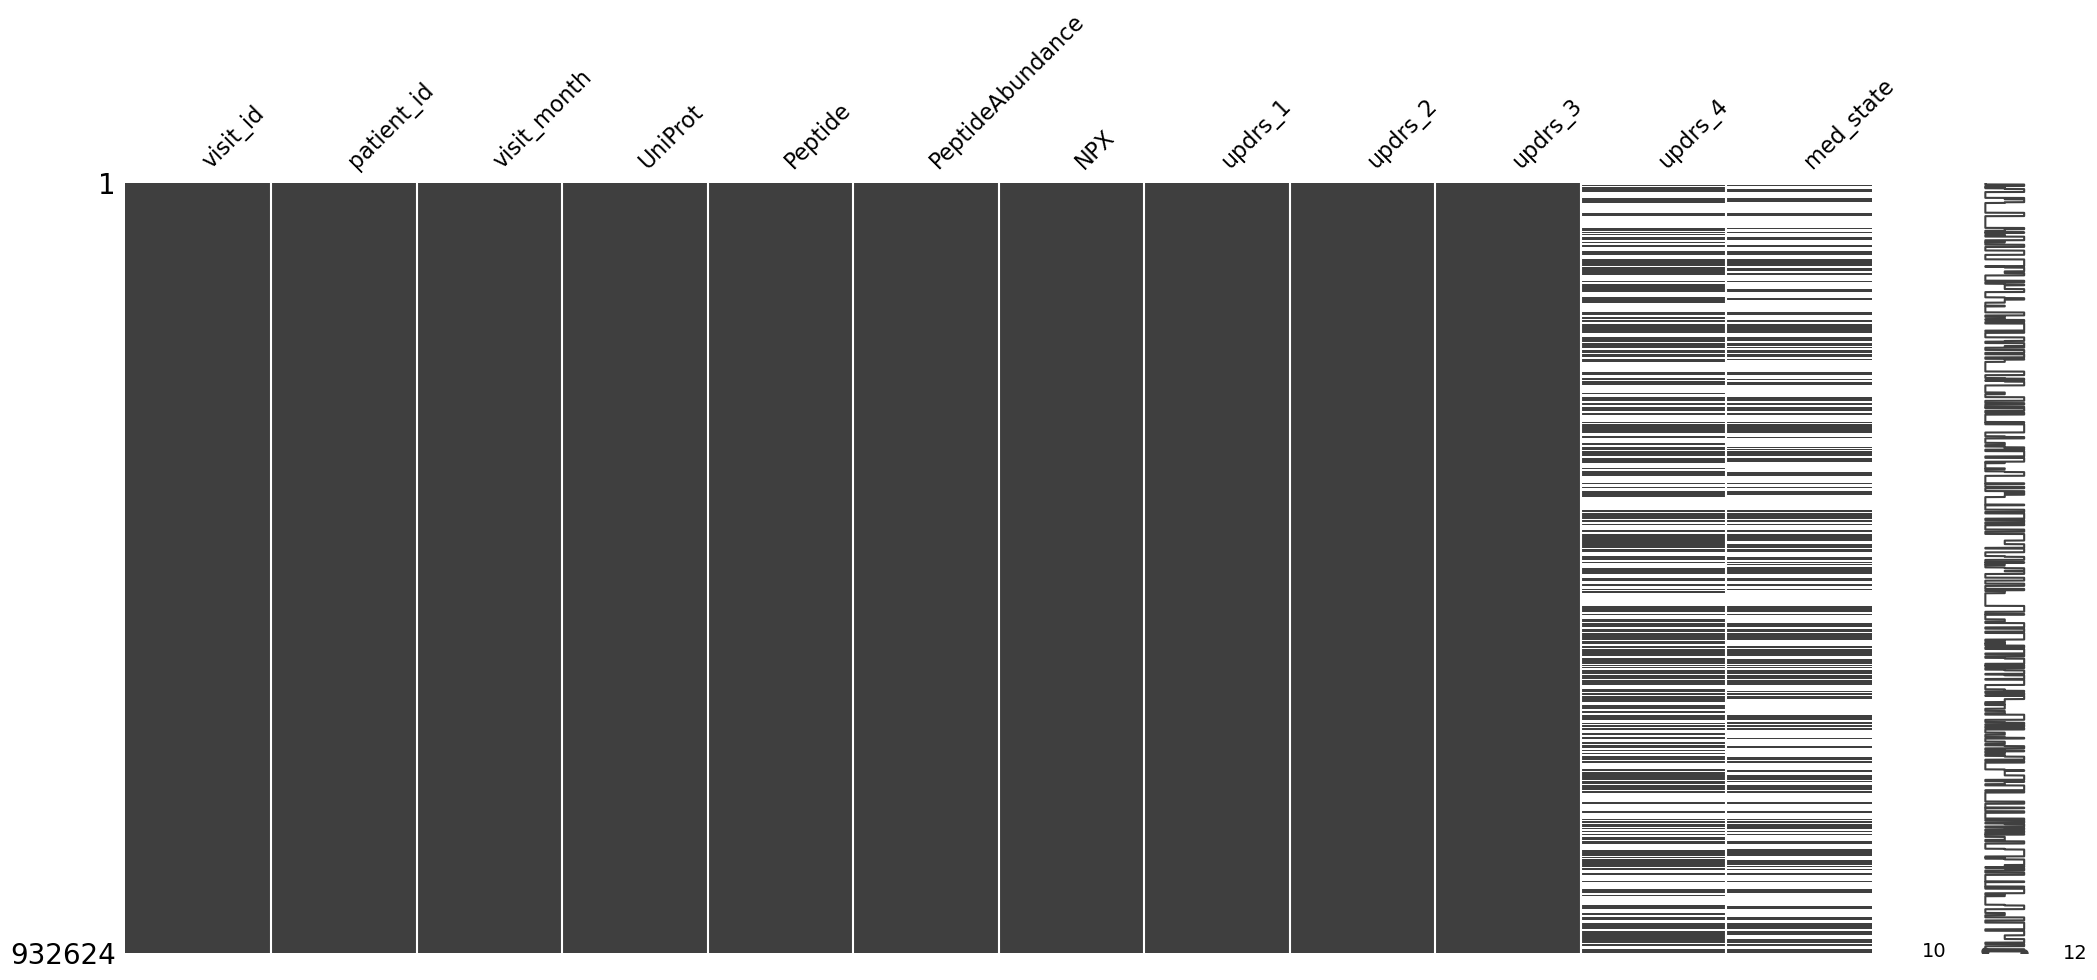

In [19]:
import missingno as msno

msno.matrix(data_val)

In [20]:
# method 1: Mean Imputation of 'updrs_4' and 'med_state'

data_val_mean = data_val.copy()
mean_imputer = SimpleImputer(strategy='mean')
data_val_mean['updrs_4'] = mean_imputer.fit_transform(data_val_mean['updrs_4'].values.reshape(-1,1))
data_val_mean['med_state'] = mean_imputer.fit_transform(data_val_mean['med_state'].values.reshape(-1,1))

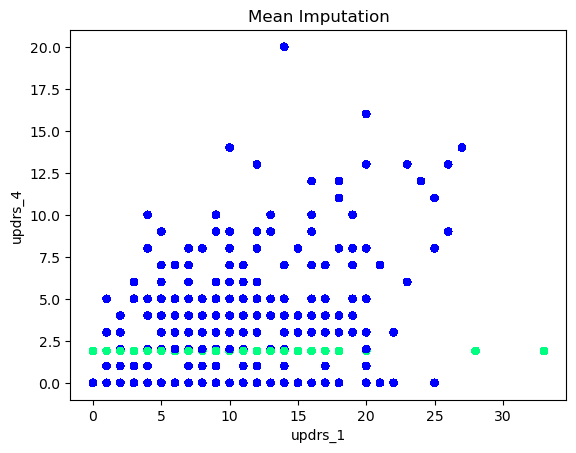

In [21]:
# Scatter plot

fig = plt.Figure()
null_values = data_val['updrs_4'].isnull()
fig = data_val_mean.plot(x="updrs_1", y='updrs_4', kind='scatter', c=null_values, cmap='winter', title='Mean Imputation', colorbar=False)


<AxesSubplot:>

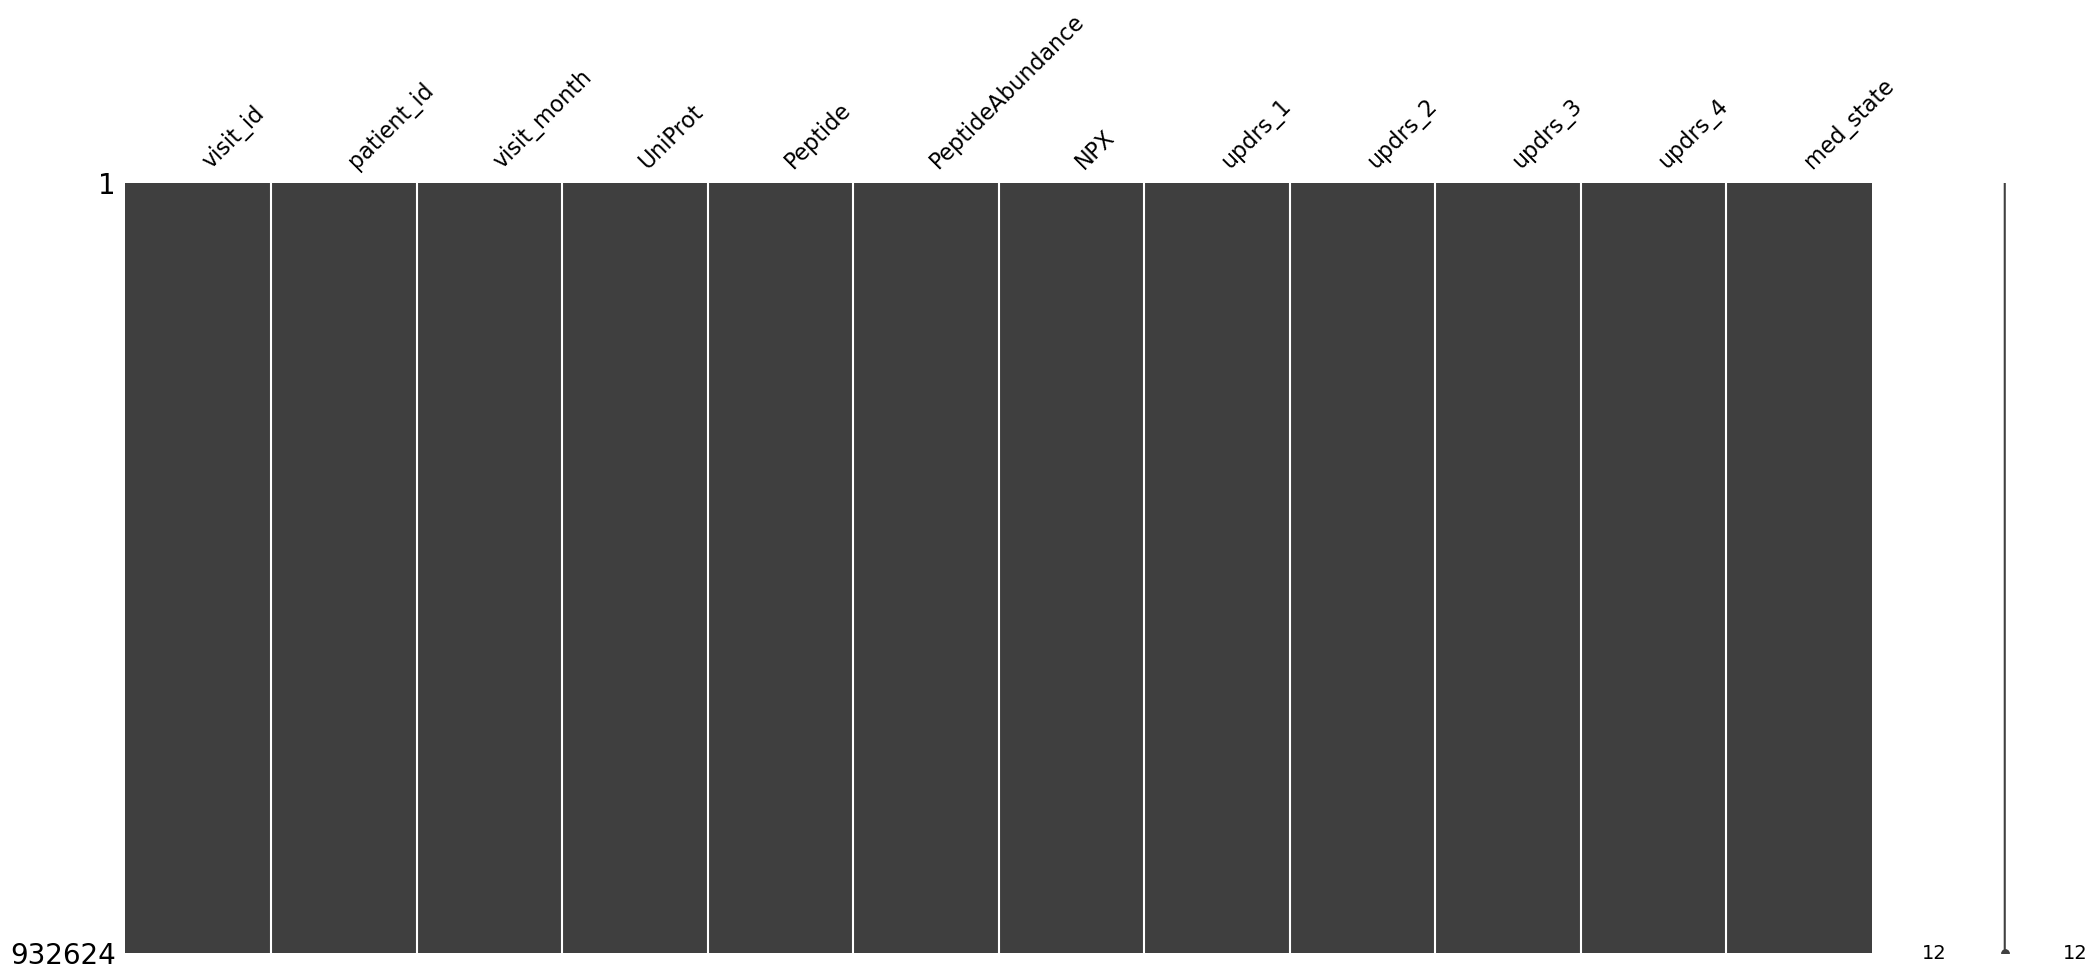

In [22]:
msno.matrix(data_val_mean)

In [23]:
# # Vizualizin after dropping values
# # figzise = (w,h)
# fig, axs = plt.subplots(1, 2, figsize=(15,5))
# fig.subplots_adjust(hspace=0.5, wspace=0.75)
# sns.heatmap(supp_val.isnull(), ax=axs[0])
# sns.heatmap(clinical_val.isnull(), ax=axs[1])

# # Set titles for each subplot
# axs[0].set_title('Supplemental')
# axs[1].set_title('Clinical')

# plt.show()


In [24]:
# # np.sort(supp["updrs_2"].unique())
# print(np.sort(supp["updrs_4"].unique()))
# print(supp["med_state"].unique())

In [25]:
# # cleaning the data
# print('\033[1m' + '\nsupplemental data stats:\n' + '\033[0m',supp.isnull().sum())
# print('\033[1m' + '\nclinical data stats:\n' + '\033[0m',clinical.isnull().sum())
# print('\033[1m' + '\npeptides data stats:\n' + '\033[0m',peptides.isnull().sum())
# print('\033[1m' + '\nprotein data stats:\n' + '\033[0m',proteins.isnull().sum())

In [26]:
# #checking for null values
# import seaborn as sns
# from matplotlib import pyplot as plt
# plt.subplot(1,2,1)
# sns.heatmap(supp.isnull())
# # plt.show()

# plt.subplot(1,2,2)
# sns.heatmap(clinical.isnull())

# plt.subplot(2,2,1)
# sns.heatmap(peptides.isnull())

# plt.subplot(2,2,2)
# sns.heatmap(proteins.isnull())

In [27]:
# # checking shape of data
# print("supplemental: {a}\nclinical: {b}\npeptides: {c}\nprotein: {d}\n".format(a = supp.shape,b = clinical.shape,c = peptides.shape,d = proteins.shape,))

In [28]:
# # np.sort(supp["updrs_2"].unique())
# print(np.sort(supp["updrs_4"].unique()))
# print(supp["med_state"].unique())

In [29]:
# implementing XGboost
!pip install sklearn xgboost

# dependencies
# import os, sys
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

  Preparing metadata (setup.py) ... - done
  Created wheel for sklearn: filename=sklearn-0.0.post1-py3-none-any.whl size=2344 sha256=8958ab98448183fb0c2a9c539b7379d350935211604d802146c90e2afed420ad
  Stored in directory: /root/.cache/pip/wheels/15/9a/b1/2478e73a520d596fab614693f5cd1beef4ba3db737bed1ac7d
Successfully built sklearn


In [30]:
# #DataFlair - Get the features and labels
# features = df.loc[:,df.columns!='status'].values[:,1:]
# labels = df.loc[:,'status'].values